In [1]:
import pandas as pd 
from matplotlib import pyplot as plt 
import numpy as np 
import seaborn as sns

# Data Analysis

## Load Data

In [44]:
def get_data(offset , significance):
    df = pd.read_csv('../not_on_git/mw_cat/chandra_filtered_sources.csv' , index_col = 'name')
    df_id = pd.read_csv('compiled_data_v3/id_frame.csv' , index_col='name')[['offset' , 'class']]
    off = offset + 0.1
    df = pd.merge(df_id[df_id['offset']<off] , df , left_index=True , right_index =True , how='right')
    sig = significance
    df = df[df['significance']>sig]
    df = df.drop(columns = ['significance'  , 'offset' , 'ra' , 'dec', 'var_inter_hard_flag' , 'likelihood'])
    df = df.rename(columns = {
        'flux_aper_b' : 'b-csc' , 
        'flux_aper_h' : 'h-csc' ,
        'flux_aper_m': 'm-csc' ,
        'flux_aper_s': 's-csc' ,
        'flux_aper_u': 'u-csc' ,
    })
    df['class'] = df['class'].replace(np.nan , 'X')
    df = pd.merge(
        df , pd.read_csv('mw_cat/sdss.csv' , index_col='name') ,
        left_index=True , 
        right_index = True , 
        how = 'left'
    )
    df = pd.merge(
        df , pd.read_csv('mw_cat/2mass_v2.csv' , index_col='name') ,
        left_index=True , 
        right_index = True , 
        how = 'left'
    )
    df = pd.merge(
        df , pd.read_csv('mw_cat/wise_combined.csv' , index_col='name') ,
        left_index=True , 
        right_index = True , 
        how = 'left'
    )
    df = pd.merge(
        df , pd.read_csv('mw_cat/galex_combined.csv' , index_col='name') ,
        left_index=True , 
        right_index = True , 
        how = 'left'
    )
    df = pd.merge(
        df , pd.read_csv('mw_cat/gaia.csv' , index_col='name') ,
        left_index=True , 
        right_index = True , 
        how = 'left'
    )
    df['B-R'] = df['bp_mag']-df['rp_mag']
    df['G-J'] = df[ 'g_mag'] - df['Jmag']
    df['G-W2'] = df['g_mag'] - df['W2mag']
    df['Bp-H'] = df['bp_mag'] - df[ 'Hmag']
    df['Bp-W3'] = df['bp_mag'] - df['W3mag']
    df['Rp-K'] = df['rp_mag'] - df['Kmag']
    df['J-H'] = df['Jmag'] - df['Hmag']
    df['J-W1'] = df['Jmag'] - df['W1mag']
    df['W1-W2'] = df['W1mag'] - df['W2mag']

    return df

In [45]:
from utilities import deets
df = get_data(offset=1.0 , significance=0)
deets(df , 1)

_____________________________________________________
------------------------------
Number of Objects : 277596
Number of Columns : 45
------------------------------


X         269486
STAR        2853
AGN         2667
YSO         1200
HMXB         759
ULX          214
CV           169
LMXB         143
PULSAR       105
Name: class, dtype: int64

_____________________________________________________


In [46]:
x = df[df['class']!='X']
y = x['class']
#x = x.drop(columns=['class'])
u = df[df['class']=='X']
u = u[u['var_flag']==1]
u = u.drop(columns = ['class'])

## Missing values

In [77]:
miss = []
for cl in y.unique():
#    cl = 'AGN'
    temp = x[x['class']==cl].drop(columns=['class'])
    miss.append((1-temp.isna().sum(axis=0) / len(temp)).to_frame(name=cl))
miss = pd.concat(miss , axis=1)
xd = x.drop(columns=['class'])
miss.insert(0 , 'overall' , (1-xd.isna().sum(axis=0) / len(xd)).to_list())
miss = miss[['overall' , 'AGN' , 'STAR' ,'YSO' , 'CV' , 'PULSAR' , 'HMXB'  , 'LMXB' ,'ULX']]

param_dict = {
    'SDSS' : ['umag' , 'gmag' , 'imag' , 'zmag' , 'rmag'] , 
    'WISE' : ['W1mag' , 'W2mag' , 'W3mag' , 'W4mag'] , 
    'GAIA' :['g_mag' , 'bp_mag' , 'rp_mag'] , 
    '2MASS' :['Jmag' , 'Hmag' , 'Kmag'] , 
    'GALEX' :['fuv_mag' , 'nuv_mag']
}
param_dict['inter-obs-var'] = ['var_inter_prob_b' , 'var_inter_sigma_b' , 'var_inter_index_b']
param_dict['intra-obs-var'] = ['var_intra_prob_b' , 'kp_intra_prob_b' , 'var_intra_index_b']
comb = ['WISE' , '2MASS' , 'GAIA' , 'SDSS' , 'GALEX' ,'inter-obs-var','intra-obs-var' ]
comb_df = []
for c in comb:
    comb_df.append(miss.loc[param_dict[c]].mean().to_frame(name=c).T)
comb_df = pd.concat(comb_df)
comb_df

sep_col = ['h-csc' ,'b-csc' , 'm-csc' , 'u-csc' ,'B-R' , 'G-J' , 'G-W2' , 'Bp-H' , 'Bp-W3' , 'Rp-K' , 'J-H' , 'J-W1' , 'W1-W2' ]
sep_df = miss.loc[sep_col]
sep_df
miss_comb_df = pd.concat([sep_df , comb_df]).sort_values(by='overall' , ascending=False)
miss_comb_df

,overall,AGN,STAR,YSO,CV,PULSAR,HMXB,LMXB,ULX
b-csc,0.967818,0.981627,0.952331,0.983333,0.781065,0.990476,0.986825,0.965035,0.985981
intra-obs-var,0.949322,0.985752,0.921837,0.945833,0.798817,0.952381,0.965744,0.874126,0.990654
m-csc,0.940074,0.968504,0.921486,0.949167,0.763314,0.942857,0.948617,0.804196,0.981308
h-csc,0.933909,0.972628,0.875920,0.979167,0.769231,0.904762,0.971014,0.958042,0.967290
GAIA,0.728113,0.728909,0.967403,0.715000,0.544379,0.371429,0.197628,0.223776,0.140187
B-R,0.728113,0.728909,0.967403,0.715000,0.544379,0.371429,0.197628,0.223776,0.140187
u-csc,0.688779,0.734158,0.662461,0.561667,0.597633,0.628571,0.799736,0.853147,0.785047
W1-W2,0.681628,0.869516,0.801963,0.550000,0.147929,0.085714,0.229249,0.139860,0.154206
WISE,0.678052,0.869516,0.793901,0.545000,0.147929,0.085714,0.229249,0.139860,0.154206
2MASS,0.582244,0.262842,0.959692,0.910000,0.301775,0.209524,0.115942,0.090909,0.079439


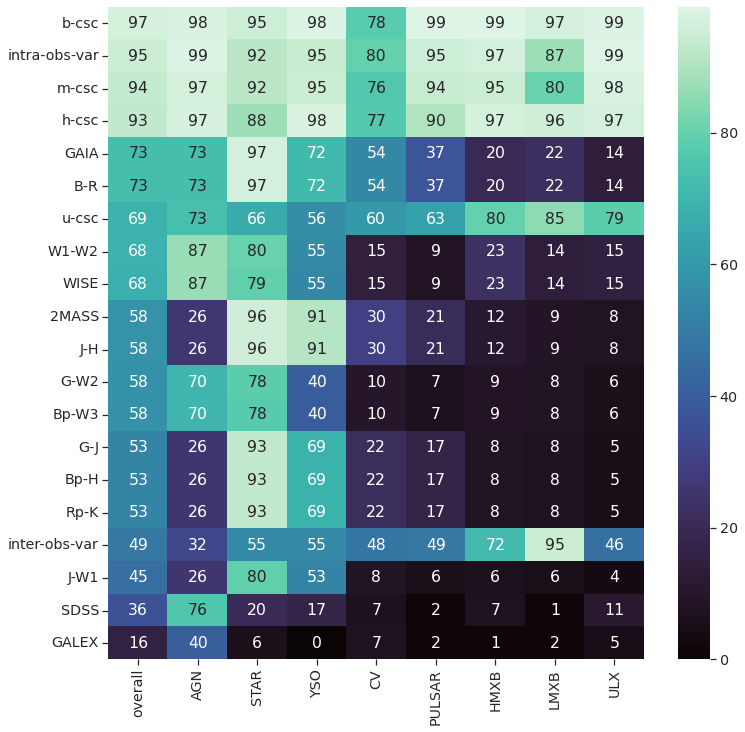

In [78]:
import seaborn as sns
sns.set(font_scale=1.3, rc={'axes.facecolor':'white', 'figure.facecolor':'white' , 'axes.grid':True} , style="ticks")
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
sns.heatmap(miss_comb_df*100 , ax=ax , annot=True , fmt='.0f' , cmap='mako')
plt.xticks(rotation=90)
#plt.savefig('final_plots/missing_features.eps' , format='eps')
#plt.savefig('final_plots/missing_features.jpg' , format='jpg')
plt.show()

# Train Classifier

In [79]:
from utilities import simple_cv
param = {
    'objective': 'binaryclass',
    'num_class':len(np.unique(y)),
    'metric': ['auc_mu' , ] , 
    'verbosity' : 2 , 
    'deterministic' : True  , 
    'early_stopping_round' : 20 , 
    'sparse' : True , 
    'is_unbalance' : True
    }
def calc_weight(gamma , y):
    l = len(y)
    cl_weight = {}
    cl_dict = y.value_counts().to_dict()
    for cl , val in zip(cl_dict.keys() , cl_dict.values()):
        w = np.exp((l / val)*gamma)
        cl_weight[cl] = w
    #print(cl_weight)
    return cl_weight

In [80]:
class make_model():
    def __init__(self , name , clf , gamma ,x ,y):
        self.name = name 
        self.clf = clf 
        self.gamma = gamma 
        self.x = x 
        self.y = y 
        
    def validate(self , fname= '' , k=10 , normalize_prob=0 , score_average = 'macro'):
        from utilities import simple_cv
        #self.weight = self.calc_weight(self.gamma ,self.y)
        res = simple_cv(self.x,self.y , model=self.clf , k=k , normalize_prob=normalize_prob , score_average = score_average)
        res['gamma'] = self.gamma 
        #res['class_weight'] = calc_weight(slef)
        print(res['class_scores'].to_markdown())
        self.result = res
        if(fname):
            import joblib
            joblib.dump(res , fname)
        return self
    
    def train(self):
        clf = self.clf
        clf.fit(self.x , self.y)
        return self
    def save(self , fname):
        import joblib
        joblib.dump(self , fname)

In [82]:
xn = x.drop(columns=['class'])
y = x['class']

In [83]:
import pandas as pd 
from matplotlib import pyplot as plt 
import numpy as np 
import seaborn as sns 
import lightgbm as lgb 
%load_ext autoreload
%autoreload 2

In [84]:
gamma = 0.07
cl_weight = calc_weight(gamma , y)
clf = lgb.LGBMClassifier(n_estimators = 100 ,class_weight = cl_weight , objective= 'multiclass', sparse=True , is_unbalance=True , metric=['auc_mu'] ,verbosity = 0 , random_state=42 , num_class=len(np.unique(y)) ,force_col_wise=True)
model = make_model('lightGBM' , clf ,gamma , xn,y)
model.validate(k=20)
model.train()

>>> GOING for 1 / 20 Iteration FOLD
>>> GOING for 2 / 20 Iteration FOLD
>>> GOING for 3 / 20 Iteration FOLD
>>> GOING for 4 / 20 Iteration FOLD
>>> GOING for 5 / 20 Iteration FOLD
>>> GOING for 6 / 20 Iteration FOLD
>>> GOING for 7 / 20 Iteration FOLD
>>> GOING for 8 / 20 Iteration FOLD
>>> GOING for 9 / 20 Iteration FOLD
>>> GOING for 10 / 20 Iteration FOLD
>>> GOING for 11 / 20 Iteration FOLD
>>> GOING for 12 / 20 Iteration FOLD
>>> GOING for 13 / 20 Iteration FOLD
>>> GOING for 14 / 20 Iteration FOLD
>>> GOING for 15 / 20 Iteration FOLD
>>> GOING for 16 / 20 Iteration FOLD
>>> GOING for 17 / 20 Iteration FOLD
>>> GOING for 18 / 20 Iteration FOLD
>>> GOING for 19 / 20 Iteration FOLD
>>> GOING for 20 / 20 Iteration FOLD
| class   |   recall_score |   precision_score |   f1_score |
|:--------|---------------:|------------------:|-----------:|
| AGN     |       0.982002 |          0.966064 |   0.973968 |
| CV      |       0.56213  |          0.637584 |   0.597484 |
| HMXB    |       0.9

In [85]:
model.train()

In [87]:
model.result['res_table'].to_csv('temp_res_comp/train_prob/new-data_lightGBM.csv')
#model.train()
model.save('models/lightGBM-new-final.pkl')

# Application

In [88]:
import joblib 
model = joblib.load('models/lightGBM-new-final.pkl')
clf = model.clf

In [94]:
deets(xn)
deets(u)

_____________________________________________________
------------------------------
Number of Objects : 8110
Number of Columns : 44
_____________________________________________________
_____________________________________________________
------------------------------
Number of Objects : 37778
Number of Columns : 44
_____________________________________________________


In [95]:
from utilities import softmax , norm_prob
pred_prob = (clf.predict_proba(u))
pred_prob_df = pd.DataFrame(pred_prob , columns=[f'prob_{el}' for el in clf.classes_] , index = u.index.to_list())
pred_prob_df

,prob_AGN,prob_CV,prob_HMXB,prob_LMXB,prob_PULSAR,prob_STAR,prob_ULX,prob_YSO
2CXO J004829.5-732959,0.151132,0.076053,0.545573,0.000359,0.064724,0.007528,0.154219,0.000412
2CXO J005449.0-725128,0.002289,0.000265,0.995992,0.000003,0.000136,0.000232,0.001077,0.000005
2CXO J010049.1-731526,0.002547,0.000119,0.396362,0.000020,0.589644,0.000497,0.010795,0.000016
2CXO J010049.8-731045,0.000259,0.000114,0.997788,0.000007,0.000188,0.000204,0.001434,0.000007
2CXO J010647.7-730940,0.009039,0.018644,0.585194,0.000472,0.370751,0.006395,0.009402,0.000102
...,...,...,...,...,...,...,...,...
2CXO J220433.1-495916,0.001958,0.008572,0.139014,0.000660,0.286211,0.000313,0.563191,0.000080
2CXO J220508.3-495935,0.027021,0.023974,0.923484,0.000627,0.011467,0.000420,0.012929,0.000078
2CXO J220544.0-495505,0.096923,0.016746,0.872905,0.000385,0.000437,0.004377,0.008073,0.000153
2CXO J220555.6-500837,0.008535,0.046435,0.569238,0.000652,0.001925,0.000516,0.372619,0.000080


In [96]:
u_df = pd.DataFrame({
    'name' : u.index.to_list() , 
    'class' : clf.predict(u) , 
    'prob' : [np.amax(el) for el in pred_prob] ,
    'prob_margin' : [el[-1]-el[-2] for el in np.sort(pred_prob , axis=1 ,)]
}).set_index('name')
u_df = pd.merge(u_df , pred_prob_df , left_index=True , right_index=True)
u_df.index.name = 'name'
u_df 

,class,prob,prob_margin,prob_AGN,prob_CV,prob_HMXB,prob_LMXB,prob_PULSAR,prob_STAR,prob_ULX,prob_YSO
name,,,,,,,,,,,
2CXO J004829.5-732959,HMXB,0.545573,0.391355,0.151132,0.076053,0.545573,0.000359,0.064724,0.007528,0.154219,0.000412
2CXO J005449.0-725128,HMXB,0.995992,0.993703,0.002289,0.000265,0.995992,0.000003,0.000136,0.000232,0.001077,0.000005
2CXO J010049.1-731526,PULSAR,0.589644,0.193281,0.002547,0.000119,0.396362,0.000020,0.589644,0.000497,0.010795,0.000016
2CXO J010049.8-731045,HMXB,0.997788,0.996354,0.000259,0.000114,0.997788,0.000007,0.000188,0.000204,0.001434,0.000007
2CXO J010647.7-730940,HMXB,0.585194,0.214443,0.009039,0.018644,0.585194,0.000472,0.370751,0.006395,0.009402,0.000102
...,...,...,...,...,...,...,...,...,...,...,...
2CXO J220433.1-495916,ULX,0.563191,0.276980,0.001958,0.008572,0.139014,0.000660,0.286211,0.000313,0.563191,0.000080
2CXO J220508.3-495935,HMXB,0.923484,0.896463,0.027021,0.023974,0.923484,0.000627,0.011467,0.000420,0.012929,0.000078
2CXO J220544.0-495505,HMXB,0.872905,0.775981,0.096923,0.016746,0.872905,0.000385,0.000437,0.004377,0.008073,0.000153


In [97]:
u_df['class'].value_counts()

AGN       9756
YSO       7428
PULSAR    5582
HMXB      4418
ULX       4072
CV        3905
STAR      2302
LMXB       315
Name: class, dtype: int64